# PBMCs Tutorial
PBMC stands for Peripheral Blood Mononuclear Cells, a vital group of immune system cells found in the blood

## 0. Initial setup
- Install LINGER according to the [GitHub](https://github.com/Durenlab/LINGER)

In [ ]:
%%bash
# conda create -n LINGER python==3.10.0
# conda activate LINGER
# pip install LingerGRN==1.105
# conda install -c bioconda bedtools  # Requirement

- Register the kernel

In [ ]:
%%bash
# pip install ipykernel
# python -m ipykernel install --user --name LINGER --display-name "Python (LINGER)"

- Verify installation

In [2]:
!pip show LingerGRN

Name: LingerGRN
Version: 1.105
Summary: Gene regulatory network inference
Home-page: https://github.com/Durenlab/LINGER
Author: Kaya Yuan
Author-email: qyyuan33@gmail.com
License: MIT
Location: /opt/conda/envs/LINGER/lib/python3.10/site-packages
Requires: anndata, joblib, matplotlib, numpy, pandas, pybedtools, rpy2, scanpy, scikit-learn, scipy, seaborn, shap, statsmodels, torch, umap-learn
Required-by: 


In [3]:
!conda info --envs


# conda environments:
#
# * -> active
# + -> frozen
base                     /opt/conda
LINGER               *   /opt/conda/envs/LINGER



In [ ]:
!conda list -n LINGER                    # lists all packages in LINGER env

In [ ]:
!conda list -n LINGER LingerGRN          # look for package LingerGRN in LINGER env

- Check ressources

In [5]:
!nproc --all

32


In [6]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           129Gi        14Gi       108Gi       170Mi       8.0Gi       115Gi
Swap:             0B          0B          0B


In [ ]:
!nvidia-smi

In [13]:
import torch
print(f"GPU: {torch.cuda.get_device_name(0)}") if torch.cuda.is_available() else print("No GPU detected")

GPU: NVIDIA RTX 6000 Ada Generation


## 1. Download the general gene regulatory network
This is the pretrained NN on bulk multiomics data across tissues : RNA-seq (gene expr.) and ATAC-seq (chrom. acc.) that will then be fine tuned with our single cell data. There is one pretrained NN per gene.

### About the bulk GRN

It contains three types of interactions (TF-RE-TG) : 
- TF &rarr; RE : biding strength (&alpha;)
- RE &rarr; TG : cis regulatory strength (&beta;)
- TF &rarr; TG : trans regulatory strength (&gamma;)

We obtain **&alpha;** by extracting the weights from the input layer to the second layer (each TF and RE are connected to the 64 hidden neurons of h1). An embedding of a TF/RE is a vector of weitghs, we can then measure how similar two embeddings are. If a TF and RE have similar learned representations, they are likely to interact and will have a high biding strength.<br><br>
We get **&beta;** and **&gamma;** using the average shapley value (that calculates the contribution of a feature to the prediction) over all cells.

In [7]:
!pwd

/globalsc/users/v/a/vangysel/Linger


In [1]:
%%bash
# Set directories and download general GRN
Datadir=$GLOBALSCRATCH/Linger/LINGER_data                     
mkdir -p $Datadir   
    
# Download general GRN from Google Drive
wget -nv -O $Datadir --load-cookies /tmp/cookies.txt "https://drive.usercontent.google.com/download?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.usercontent.google.com/download?id=1jwRgRHPJrKABOk7wImKONTtUupV7yJ9b'  -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jwRgRHPJrKABOk7wImKONTtUupV7yJ9b" -O data_bulk.tar.gz
rm -rf /tmp/cookies.txt

2026-02-10 12:28:35 URL:https://drive.usercontent.google.com/download?export=download&confirm=&id=1jwRgRHPJrKABOk7wImKONTtUupV7yJ9b [20812483490/20812483490] -> "data_bulk.tar.gz" [1]


In [ ]:
!tar -xzf data_bulk.tar.gz

## 2. Prepare the input data

- Download the h5 file (the matrix contains both RNA and ATAC data combined)

In [32]:
%%bash
mkdir -p data
wget --progress=bar:force -O data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5

--2026-02-04 15:24:27--  https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162282142 (155M) [binary/octet-stream]
Saving to: ‘data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5’

data/pbmc_granulocy 100%[===================>] 154.76M   109MB/s    in 1.4s    

2026-02-04 15:24:29 (109 MB/s) - ‘data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5�� saved [162282142/162282142]



- Download cell annotation

In [14]:
%%bash
wget --progress=bar:force -O data --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_" -O PBMC_label.txt && rm -rf /tmp/cookies.txt

--2026-02-09 12:35:13--  https://docs.google.com/uc?export=download&confirm=&id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_
Resolving docs.google.com (docs.google.com)... 173.194.76.100, 173.194.76.113, 173.194.76.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.76.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_&export=download [following]
--2026-02-09 12:35:13--  https://drive.usercontent.google.com/download?id=17PXkQJr8fk0h90dCkTi3RGPmFNtDqHO_&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.206.132, 2a00:1450:400c:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.206.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 362958 (354K) [application/octet-stream]
Saving to: ‘PBMC_label.txt’

PBMC_label.txt      100%[===================>] 354.45K  --.-K

In [2]:
import scanpy as sc
import scipy.sparse as sp
import pandas as pd

adata = sc.read_10x_h5('data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5', gex_only=False)
adata

/opt/conda/envs/LINGER/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11909 × 144978
    var: 'gene_ids', 'feature_types', 'genome'

In [9]:
len(adata.var.index) - len(adata.var.index.unique()) 

10

In [8]:
#adata.var_names_make_unique()     # only 10 var are not unique, we make them unique [USEFUL ??]

In [3]:
matrix = adata.X.T    # linger expects k_features x n_cells
adata.var['gene_ids'] = adata.var.index

# features are genes and peaks grouped together (col1 for gene/peak name and col2 for category: gene or peak)
features = pd.DataFrame(adata.var['gene_ids'].values.tolist(),columns=[1])
features[2] = adata.var['feature_types'].values

barcodes = pd.DataFrame(adata.obs_names,columns=[0])
label = pd.read_csv('data/PBMC_label.txt',sep='\t',header=0)

In [4]:
from LingerGRN.preprocess import *
adata_RNA, adata_ATAC = get_adata(matrix,features,barcodes,label)     # adata_RNA and adata_ATAC are scRNA and scATAC

/opt/conda/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:278: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_RNA.obs['label']=label.loc[adata_RNA.obs['barcode']]['label'].values
/opt/conda/envs/LINGER/lib/python3.10/site-packages/LingerGRN/preprocess.py:281: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ATAC.obs['label']=label.loc[adata_ATAC.obs['barcode']]['label'].values


In [12]:
print(f"Features : \n\n{features.head()}")
print(f"{features.tail()}\n\n")
print(f"Barcodes: \n{barcodes.head()}\n\n")
print(f"Labels : \n{label.head()}\n")

Features : 

             1                2
0  MIR1302-2HG  Gene Expression
1      FAM138A  Gene Expression
2        OR4F5  Gene Expression
3   AL627309.1  Gene Expression
4   AL627309.3  Gene Expression
                             1      2
144973  KI270713.1:20444-22615  Peaks
144974  KI270713.1:27118-28927  Peaks
144975  KI270713.1:29485-30706  Peaks
144976  KI270713.1:31511-32072  Peaks
144977  KI270713.1:37129-37638  Peaks


Barcodes: 
                    0
0  AAACAGCCAAGGAATC-1
1  AAACAGCCAATCCCTT-1
2  AAACAGCCAATGCGCT-1
3  AAACAGCCACACTAAT-1
4  AAACAGCCACCAACCG-1


Labels : 
                           barcode_use               label
barcode_use                                               
AAACAGCCAAGGAATC-1  AAACAGCCAAGGAATC-1   naive CD4 T cells
AAACAGCCAATCCCTT-1  AAACAGCCAATCCCTT-1  memory CD4 T cells
AAACAGCCAATGCGCT-1  AAACAGCCAATGCGCT-1   naive CD4 T cells
AAACAGCCAGTAGGTG-1  AAACAGCCAGTAGGTG-1   naive CD4 T cells
AAACAGCCAGTTTACG-1  AAACAGCCAGTTTACG-1  memory CD4 T cel

### 2.1 About the `get_data()` function
**@inputs :** 
- matrix: sparse matrix with RNA and ATAC data stacked vertically
- features: gene/peak IDs and their types ('Gene Expression' or 'Peaks')
- barcodes: cell barcodes
- label: cell type labels/annotations 

**@outputs :**
- adata_RNA 
- adata_ATAC

In [19]:
# gene - cell 
print(adata.var.iloc[0], end="\n\n")
print(adata.obs.iloc[0])

gene_ids             MIR1302-2HG
feature_types    Gene Expression
genome                    GRCh38
Name: MIR1302-2HG, dtype: object

Series([], Name: AAACAGCCAAGGAATC-1, dtype: float64)


In [20]:
adata

AnnData object with n_obs × n_vars = 11909 × 144978
    var: 'gene_ids', 'feature_types', 'genome'

In [21]:
adata.obs.head()

""
AAACAGCCAAGGAATC-1
AAACAGCCAATCCCTT-1
AAACAGCCAATGCGCT-1
AAACAGCCACACTAAT-1
AAACAGCCACCAACCG-1


In [24]:
adata.var.head()

,gene_ids,feature_types,genome
MIR1302-2HG,MIR1302-2HG,Gene Expression,GRCh38
FAM138A,FAM138A,Gene Expression,GRCh38
OR4F5,OR4F5,Gene Expression,GRCh38
AL627309.1,AL627309.1,Gene Expression,GRCh38
AL627309.3,AL627309.3,Gene Expression,GRCh38


## 4. About the AnnData object

In [25]:
adata            # cells x (genes + peaks) 

AnnData object with n_obs × n_vars = 11909 × 144978
    var: 'gene_ids', 'feature_types', 'genome'

In [26]:
adata_RNA        # cells x genes 

View of AnnData object with n_obs × n_vars = 9543 × 36601
    obs: 'barcode', 'sample', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [27]:
adata_ATAC       # cells x peaks

View of AnnData object with n_obs × n_vars = 9543 × 108377
    obs: 'barcode', 'sample', 'label'
    var: 'gene_ids'

In [28]:
#adata_RNA.X[i, j]             # cell i, gene j : Gene expression count of gene j in cell i
#adata_ATAC.X[i, k]            # cell i, peak k : Chromatin accessibility count of peak k in cell i
adata_RNA.X[1, 44]             # cell 1 gene 44

0.0

In [29]:
adata_RNA.X[0, :10].toarray()     # cell 0, expr. of 10 first genes

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [30]:
adata_RNA.X[:10, 0].toarray()     # gene 0 expr. in 10 first cells

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [32]:
adata_RNA.obs.iloc[:10]            # metadata of 10 first cells

,barcode,sample,label,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
7700,GGCTTCAAGGCGGGTA-1,1,CD56 (bright) NK cells,1422,2515.0,0.0,0.0
11483,TTGCACACAGTAATAG-1,1,non-classical monocytes,2309,5141.0,0.0,0.0
8165,GGTTTCTGTGGTGAGA-1,1,classical monocytes,1660,3303.0,0.0,0.0
10288,TCTATGTTCGGTAACT-1,1,naive CD8 T cells,1429,2782.0,0.0,0.0
5734,CTTGTTCCACTTCATC-1,1,classical monocytes,2482,6116.0,0.0,0.0
6185,GAGGCTTGTATCTGGA-1,1,classical monocytes,1866,3868.0,0.0,0.0
2446,ATGACGAAGTAACAGG-1,1,memory CD4 T cells,1493,2872.0,0.0,0.0
3399,CATAAGCTCTGTAATG-1,1,naive CD8 T cells,1654,3500.0,0.0,0.0
95,AAAGGCTCACCTACGG-1,1,classical monocytes,2116,5130.0,0.0,0.0
1921,AGGTTGCGTTTAGTCC-1,1,effector CD8 T cells,1748,3562.0,0.0,0.0


In [33]:
adata_RNA.var.iloc[:10]            # metadata of 10 first genes

,gene_ids,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,MIR1302-2HG,False,0,0.000000,100.000000,0.0
FAM138A,FAM138A,False,0,0.000000,100.000000,0.0
OR4F5,OR4F5,False,0,0.000000,100.000000,0.0
AL627309.1,AL627309.1,False,61,0.006916,99.360788,66.0
AL627309.3,AL627309.3,False,0,0.000000,100.000000,0.0
AL627309.2,AL627309.2,False,0,0.000000,100.000000,0.0
AL627309.5,AL627309.5,False,408,0.046002,95.724615,439.0
AL627309.4,AL627309.4,False,41,0.004401,99.570366,42.0
AP006222.2,AP006222.2,False,1,0.000105,99.989521,1.0
AL732372.1,AL732372.1,False,0,0.000000,100.000000,0.0


## 5. Preprocess

In [5]:
# Filter low-count cells and genes

# Keep only cells that have ≥ 200 detected genes
sc.pp.filter_cells(adata_RNA, min_genes=200)

# Keep only genes expressed in ≥ 3 cells
sc.pp.filter_genes(adata_RNA, min_cells=3)

sc.pp.filter_cells(adata_ATAC, min_genes=200)
sc.pp.filter_genes(adata_ATAC, min_cells=3)

# Keep only cells present in both RNA and ATAC
selected_barcode = list(set(adata_RNA.obs['barcode'].values) & set(adata_ATAC.obs['barcode'].values))

barcode_idx = pd.DataFrame(range(adata_RNA.shape[0]), index=adata_RNA.obs['barcode'].values)
adata_RNA = adata_RNA[barcode_idx.loc[selected_barcode][0]]

barcode_idx = pd.DataFrame(range(adata_ATAC.shape[0]), index=adata_ATAC.obs['barcode'].values)
adata_ATAC = adata_ATAC[barcode_idx.loc[selected_barcode][0]]


/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


### 5.1 Effect of preprocess
We had 9543 cells and 144 978 features :
- 36 601 genes
- 108 377 peaks


In [35]:
print(f"adata_RNA.shape : {adata_RNA.shape}")
print(f"adata_ATAC.shape : {adata_ATAC.shape}")

adata_RNA.shape : (9543, 25485)
adata_ATAC.shape : (9543, 107208)


### 5.2 Comparison with uncompressed data

- Uncompressed : 
    - adata_RNA.shape : (9543, 36601)
    - adata_ATAC.shape : (9543, 143887)
- Compressed (.h5 file only)
    - adata_RNA.shape : (9543, 36601)
    - adata_ATAC.shape : (9543, 108377)

**After preprocessing**

- Uncompressed : 
    - adata_RNA.shape : (9543, 25485)
    - adata_ATAC.shape : (9543, 143885)


- Compressed (.h5 file only)
    - adata_RNA.shape : (9543, 25485)
    - adata_ATAC.shape : (9543, 107208)


### 5.3 About pseudo-bulking

Pseudo-bulk means "Combine many single cells into a “fake bulk sample” by summing or averaging their counts"
Since single cell is noisy and extremely sparse, it is better to work with aggregated signals across groups of cells (=metacells).  
- ``singlepseudobulk = true`` : Collapse all cells in this sample into ONE pseudobulk profile. This gives following dimensions : 
    - TG_pseudobulk_temp : (n_genes × 1)
    - RE_pseudobulk_temp : (n_peaks × 1) <br><br>
      
- ``singlepseudobulk = false`` : First cluster cells → then make multiple pseudobulks (metacells), used when we don't have many samples. This will create *K* clusters of cells, or *K* metacells
    - TG_pseudobulk_temp : (n_genes × k_metacells)
    - RE_pseudobulk_temp : (n_peaks × k_metacells) <br><br>
      
- Why is this needed ? GRN inference needs many samples (columns).
    - If you already have many samples → 1 bulk per sample is enough
    - If you have few samples → create metacells to increase sample count
      


In [ ]:
adata_RNA[adata_RNA.obs['sample' ] == tempsample]

In [6]:
# Generate pseudo-bulk/metacell
import os
from LingerGRN.pseudo_bulk import *

samplelist=list(set(adata_ATAC.obs['sample'].values)) # sample is generated from cell barcode 
tempsample=samplelist[0]

TG_pseudobulk=pd.DataFrame([])
RE_pseudobulk=pd.DataFrame([])

n_samples = adata_RNA.obs['sample'].nunique()
singlepseudobulk = (n_samples > 10)
#singlepseudobulk = (adata_RNA.obs['sample'].unique().shape[0]*adata_RNA.obs['sample'].unique().shape[0]>100)

# here samplelist = [1], singlepseudobulk = False (there is only one sample)
for tempsample in samplelist:

    # get cells from only tempsample
    adata_RNAtemp = adata_RNA[adata_RNA.obs['sample' ] == tempsample]
    adata_ATACtemp = adata_ATAC[adata_ATAC.obs['sample'] == tempsample]

    TG_pseudobulk_temp, RE_pseudobulk_temp = pseudo_bulk(adata_RNAtemp, adata_ATACtemp, singlepseudobulk)  
    
    TG_pseudobulk = pd.concat([TG_pseudobulk, TG_pseudobulk_temp], axis=1)
    RE_pseudobulk = pd.concat([RE_pseudobulk, RE_pseudobulk_temp], axis=1)
    
    RE_pseudobulk[RE_pseudobulk > 100] = 100


/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:372: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/envs/LINGER/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### 5.4 About `pseudo_bulk` function

**@inputs :**
- adata_RNAtemp: single-cell RNA expression for one sample
- adata_ATACtemp: single-cell chromatin accessibility for the same cells
- singlepseudobulk (bool): whether to make one pseudo-bulk or multiple metacells

**@outputs :**
- TG_pseudobulk
- RE_pseudobulk

From one sample, it will either create a single metacell (single pseudobulk) or many pseudobulks. <br>
Here, we will cluster 9,543 cells into 343 metacells (9543/343 ≃ 28 cells per metacell).

In [7]:
if not os.path.exists('data/'):
    os.mkdir('data/')
    
adata_ATAC.write('data/adata_ATAC.h5ad')
adata_RNA.write('data/adata_RNA.h5ad')

TG_pseudobulk=TG_pseudobulk.fillna(0)
RE_pseudobulk=RE_pseudobulk.fillna(0)

pd.DataFrame(adata_ATAC.var['gene_ids']).to_csv('data/Peaks.txt',header=None,index=None)

TG_pseudobulk.to_csv('data/TG_pseudobulk.tsv')
RE_pseudobulk.to_csv('data/RE_pseudobulk.tsv')

/opt/conda/envs/LINGER/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/envs/LINGER/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [16]:
TG_pseudobulk        # 25 485 genes x 343 bulks (meta cells)

,AGGTCATTCCACCCTG-1,AGTAGGATCAATCATG-1,GGCGGTAAGTCATTAG-1,CTGGCTAAGGCTGTCA-1,CCCTGTTAGGTTACGT-1,ACCTTGCTCCCATAAA-1,AGCCTGGGTGCTCCAC-1,TCGGTTCTCAATCATG-1,GGTTTCCTCCTACCTA-1,AGCTTTAAGGCTACTG-1,...,AAGACCAAGTTAGACC-1,CGGAGCAAGCGCATTG-1,CTCATGCTCTGTAATG-1,TATCGCACACCTGCTC-1,GGTAACCGTCTTACTA-1,GAGAGGCGTGCATTTC-1,TAGCCTCTCTTAGCGG-1,TTGTCCCAGCACAGAA-1,TGGTTCTGTACCGGAT-1,GAGGCTTGTGCAATGC-1
AL627309.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.081956,0.000000,0.081956,0.000000,0.000000,0.081956
AL627309.5,0.000000,0.074782,0.000000,0.000000,0.000000,0.000000,0.000000,0.085525,0.085525,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL627309.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL669831.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LINC01409,0.000000,0.000000,0.000000,0.098520,0.091070,0.095236,0.000000,0.000000,0.213746,0.000000,...,0.000000,0.072137,0.000000,0.135810,0.000000,0.000000,0.000000,0.082790,0.135810,0.133361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,0.284027,0.451999,0.494313,0.104662,0.075123,0.361012,0.304580,0.408634,0.062963,0.141288,...,0.269741,0.135051,0.254054,0.061631,0.101025,0.065165,0.153150,0.050740,0.161472,0.255132
AC240274.1,0.000000,0.093759,0.000000,0.000000,0.000000,0.000000,0.134065,0.000000,0.076627,0.000000,...,0.000000,0.140692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072462
AC004556.3,0.076205,0.086451,0.000000,0.000000,0.304014,0.185236,0.000000,0.077569,0.000000,0.000000,...,0.000000,0.136775,0.000000,0.000000,0.000000,0.000000,0.000000,0.116444,0.000000,0.000000
AC007325.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
RE_pseudobulk         # 107 208 peaks x 343 bulks 

,AGGTCATTCCACCCTG-1,AGTAGGATCAATCATG-1,GGCGGTAAGTCATTAG-1,CTGGCTAAGGCTGTCA-1,CCCTGTTAGGTTACGT-1,ACCTTGCTCCCATAAA-1,AGCCTGGGTGCTCCAC-1,TCGGTTCTCAATCATG-1,GGTTTCCTCCTACCTA-1,AGCTTTAAGGCTACTG-1,...,AAGACCAAGTTAGACC-1,CGGAGCAAGCGCATTG-1,CTCATGCTCTGTAATG-1,TATCGCACACCTGCTC-1,GGTAACCGTCTTACTA-1,GAGAGGCGTGCATTTC-1,TAGCCTCTCTTAGCGG-1,TTGTCCCAGCACAGAA-1,TGGTTCTGTACCGGAT-1,GAGGCTTGTGCAATGC-1
chr1:10109-10357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.072963,0.000000,0.000000,0.036481,0.000000,0.000000,0.000000,0.000000
chr1:180730-181630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.036481,0.000000,0.036481,0.000000,0.000000,0.036481,0.000000,0.000000
chr1:191491-191736,0.000000,0.036481,0.072963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chr1:267816-268196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057822,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chr1:586028-586373,0.115643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.057822,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KI270713.1:20444-22615,0.431637,0.774517,0.431637,0.897620,0.173465,0.427587,0.761290,0.774517,0.770466,0.755091,...,0.658874,0.485409,0.115643,0.342880,0.558371,0.289109,0.473664,0.631988,0.431637,0.601052
KI270713.1:27118-28927,0.036481,0.000000,0.036481,0.000000,0.057822,0.036481,0.036481,0.000000,0.000000,0.036481,...,0.057822,0.000000,0.000000,0.057822,0.000000,0.000000,0.000000,0.000000,0.115643,0.057822
KI270713.1:29485-30706,0.000000,0.057822,0.000000,0.115643,0.000000,0.000000,0.000000,0.000000,0.000000,0.057822,...,0.057822,0.057822,0.000000,0.173465,0.000000,0.000000,0.036481,0.000000,0.115643,0.000000
KI270713.1:31511-32072,0.000000,0.000000,0.000000,0.000000,0.173465,0.000000,0.057822,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
!pwd

/globalsc/users/v/a/vangysel/Linger


## 6. Training the model

In [8]:
import os
from LingerGRN.preprocess import *

#Datadir = os.path.join(os.getcwd(), 'LINGER_data/')
Datadir = "/globalsc/ucl/inma/vangysel/Linger/" + "LINGER_data/"
GRNdir = Datadir + 'data_bulk/'
genome = 'hg38'
#outdir = '/LINGER_output/'  # output directory
outdir = "/globalsc/ucl/inma/vangysel/Linger/" + "LINGER_output/"
method = 'baseline'         # or 'LINGER'

In [9]:
preprocess(TG_pseudobulk, RE_pseudobulk, GRNdir, genome, method, outdir)

Overlap the regions with bulk data ...


In [10]:
import LingerGRN.LINGER_tr as LINGER_tr

activef='ReLU' # active function chose from 'ReLU','sigmoid','tanh'
LINGER_tr.training(GRNdir,method,outdir,activef,'Human')

## 7. Cell population GRN

### 7.1 TF binding potential (TF-RE)
The output is 'cell_population_TF_RE_binding.txt', a matrix of the TF-RE binding score.

In [11]:
import LingerGRN.LL_net as LL_net
LL_net.TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

Generating cellular population TF binding strength ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:40<00:00,  1.75s/it]


In [12]:
tf_re = pd.read_csv("LINGER_output/cell_population_TF_RE_binding.txt", sep="\t", index_col=0)
tf_re.head()

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
chr1:100028489-100029404,0.010469,0.380009,0.000000,0.412295,0.000000,0.000000,0.324316,0.000000,0.000000,0.380206,...,0.634570,0.363192,0.00000,0.225078,0.000000,0.00000,0.265811,0.000000,0.000000,0.000000
chr1:100034436-100035279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
chr1:100035922-100040109,0.000000,0.000000,0.077789,0.000000,0.093418,0.072623,0.000000,0.338647,0.386390,0.000000,...,0.000000,0.000000,0.64465,0.000000,0.291201,0.42141,0.000000,0.244719,0.315431,0.291374
chr1:100041493-100041927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
chr1:100046068-100047735,0.000000,0.000000,0.000000,0.758438,0.000000,0.000000,0.274057,0.000000,0.071968,0.228773,...,0.428219,0.104424,0.00000,0.130865,0.000000,0.00000,0.368671,0.000000,0.000000,0.000000


### 7.2 cis-regulatory network (RE-TG)
The output is 'cell_population_cis_regulatory.txt' with 3 columns: region, target gene, cis-regulatory score.

In [13]:
LL_net.cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,method,outdir)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [01:32<00:00,  4.04s/it]


In [14]:
re_tg = pd.read_csv("LINGER_output/cell_population_cis_regulatory.txt", sep="\t", index_col=0)
re_tg.columns = ['TG', 'Score']
re_tg = re_tg.reset_index()
re_tg = re_tg.rename(columns={'index': 'RE', re_tg.columns[0]: 'RE'})
re_tg.head()

,RE,TG,Score
0,chr1:100028489-100029404,SLC35A3,6.177391e-03
1,chr1:100028489-100029404,EXTL2,5.469594e-17
2,chr1:100028489-100029404,CDC14A,2.005422e-07
3,chr1:100028489-100029404,SLC30A7,5.400717e-17
4,chr1:100028489-100029404,PALMD,1.420250e-08


### 7.3 trans-regulatory network (TF-TG)
The output is 'cell_population_trans_regulatory.txt', a matrix of the trans-regulatory score.

In [15]:
LL_net.trans_reg(GRNdir,method,outdir,genome)  

Generate trans-regulatory netowrk ...
Save trans-regulatory netowrk ...


In [16]:
tf_tg = pd.read_csv("LINGER_output/cell_population_trans_regulatory.txt", sep="\t", index_col=0)
tf_tg.head()

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
LRRC39,3.782764e-08,3.211212e-07,1.020716e-07,2.470217e-05,7.661409e-07,4.684270e-07,4.855493e-07,2.294528e-06,2.349720e-05,7.411950e-06,...,1.562477e-05,2.891821e-07,3.033045e-05,8.256888e-07,8.253104e-07,2.281567e-05,4.071136e-07,3.727110e-07,1.942480e-05,1.080851e-07
SLC35A3,3.759316e-05,6.571791e-05,1.267860e-05,6.152784e-05,2.232967e-05,1.701231e-05,1.162876e-05,4.030463e-05,2.088749e-04,2.788880e-05,...,1.082445e-04,6.505713e-05,1.631155e-04,9.766670e-05,4.071283e-05,5.319896e-05,4.645208e-05,2.006835e-05,1.106104e-04,3.298994e-05
EXTL2,1.783812e-08,5.098728e-08,2.457041e-08,9.338036e-08,3.330273e-08,2.467961e-08,4.523100e-08,2.422341e-08,4.623898e-09,1.275452e-07,...,2.718584e-07,1.578006e-07,3.989572e-08,3.711081e-08,3.695238e-08,2.238947e-09,2.339493e-08,2.637933e-08,4.100492e-08,3.132873e-08
CDC14A,2.620428e-05,2.855293e-05,5.179631e-05,1.208138e-04,3.127029e-04,2.238128e-04,1.327100e-04,1.335303e-04,3.706262e-04,1.358051e-04,...,7.378141e-05,2.596146e-04,2.161623e-04,1.239594e-04,5.056820e-05,2.945779e-04,5.011532e-05,1.225452e-04,4.420266e-04,3.044869e-05
SLC30A7,1.425595e-08,5.586075e-08,3.691107e-08,7.817974e-08,4.970371e-08,3.340976e-08,3.649091e-08,1.307627e-08,2.217734e-09,1.092074e-07,...,8.834674e-08,1.198469e-07,3.154609e-08,2.173705e-08,3.410215e-08,9.536410e-10,2.169746e-08,2.844390e-08,4.659253e-08,1.302895e-08


## 8. Cell type sepecific GRN
The cell specific GRN is based on the output of the cell population GRN.

In [17]:
#celltype = 'all'                     # build a GRN for all cell types
celltype = 'naive CD4 T cells'        # only one cell type

In [18]:
label['label'].value_counts()    # all cell types

label
classical monocytes        1848
memory CD4 T cells         1540
naive CD8 T cells          1471
naive CD4 T cells          1373
intermediate monocytes      626
CD56 (dim) NK cells         453
memory B cells              400
CD56 (bright) NK cells      391
non-classical monocytes     364
effector CD8 T cells        362
naive B cells               282
myeloid DC                  232
plasmacytoid DC             103
MAIT T cells                 98
Name: count, dtype: int64

In [19]:
import inspect
import LingerGRN.LL_net as LL_net

print(inspect.signature(LL_net.cell_type_specific_trans_reg))

(GRNdir, adata_RNA, celltype, outdir)


In [20]:
# TF-RE : TF binding potential
LL_net.cell_type_specific_TF_RE_binding(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir,method)    # beware !! 'method' is last arg here

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [04:57<00:00, 12.92s/it]


In [22]:
cts_tf_re = pd.read_csv(f"LINGER_output/cell_type_specific_TF_RE_binding_{celltype}.txt", sep="\t", index_col=0)
cts_tf_re.head()

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
chr1:100028489-100029404,0.011691,0.035703,0.726139,1.158202,0.216285,0.001885,0.017278,0.138547,0.011455,0.283118,...,0.438874,0.137822,0.070377,0.010484,0.003305,0.021207,0.023862,0.944495,0.001591,0.001150
chr1:100034436-100035279,0.023741,0.025124,1.129999,0.052890,0.360638,0.003219,0.002634,0.002132,0.023077,0.300673,...,0.011079,0.361990,0.127121,0.002215,0.005644,0.042722,0.026690,1.254965,0.002717,0.001965
chr1:100035922-100040109,0.548353,0.776131,36.706507,43.672718,7.136522,0.165058,0.041107,7.648558,0.885338,5.276587,...,0.172935,11.839835,3.675329,1.684870,2.943762,1.701551,0.505818,54.267198,0.463366,1.132348
chr1:100041493-100041927,0.019009,0.023642,0.429089,0.035690,0.192402,0.002172,0.001777,0.001439,0.016175,0.160410,...,0.007476,0.549808,0.083477,0.001495,0.084010,0.029944,0.015540,0.485208,0.001834,0.032008
chr1:100046068-100047735,0.041458,0.054320,2.200433,1.315087,0.414398,0.003219,0.025344,0.002132,0.052460,0.451131,...,0.596499,0.827910,0.270746,0.011338,0.148179,0.088880,0.054906,1.953833,0.002717,0.058030


In [24]:
# RE-TG : cis-regulatory network
LL_net.cell_type_specific_cis_reg(GRNdir,adata_RNA,adata_ATAC,genome,celltype,outdir,method)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:54<00:00,  2.39s/it]


In [25]:
cts_re_tg = pd.read_csv(f"LINGER_output/cell_type_specific_cis_regulatory_{celltype}.txt", sep="\t", index_col=0)
cts_re_tg.columns = ['TG', 'Score']
cts_re_tg = cts_re_tg.reset_index()
cts_re_tg = cts_re_tg.rename(columns={'index': 'RE', cts_re_tg.columns[0]: 'RE'})
cts_re_tg.head()

,RE,TG,Score
0,chr1:100028489-100029404,SLC35A3,9.476595e-04
1,chr1:100028489-100029404,EXTL2,1.034138e-18
2,chr1:100028489-100029404,CDC14A,2.475391e-07
3,chr1:100028489-100029404,SLC30A7,1.235029e-17
4,chr1:100028489-100029404,PALMD,1.721386e-10


In [26]:
# TF-TG : trans-regulatory network
LL_net.cell_type_specific_trans_reg(GRNdir,adata_RNA,celltype,outdir)

In [27]:
cts_tf_tg = pd.read_csv(f"LINGER_output/cell_type_specific_trans_regulatory_{celltype}.txt", sep="\t", index_col=0)
cts_tf_tg.head()

,ALX4,POU3F1,FOXJ3,MAX,HSF2,ZFP3,GZF1,GLI2,HOXB7,HSF1,...,RELA,ARID5A,PBX2,MLXIPL,MEF2C,HOXB4,MSX2,TCF12,MECOM,NFATC4
LRRC39,0.001807,0.002110,0.069258,0.113081,0.020018,0.000177,0.000130,0.002453,0.002873,0.017265,...,0.018907,0.034118,0.021282,0.005007,0.005186,0.004744,0.001504,0.116999,0.001148,0.002493
SLC35A3,0.024132,0.030200,1.166244,2.081202,0.306637,0.004668,0.002003,0.149747,0.041462,0.242740,...,0.039931,0.444848,0.175072,0.078115,0.060856,0.061727,0.025831,1.974466,0.019334,0.044588
EXTL2,0.008358,0.012103,0.386301,0.573948,0.083128,0.000749,0.000613,0.000529,0.007785,0.069306,...,0.109420,0.181799,0.103168,0.022412,0.026274,0.014413,0.007783,0.451091,0.020371,0.011782
CDC14A,1.160490,1.432674,82.355848,82.074478,19.709333,0.112997,0.085592,0.383262,2.244019,16.418700,...,15.272160,23.330261,12.488142,2.561499,3.505493,3.766569,0.986419,84.093245,1.643556,1.318649
SLC30A7,0.101183,0.146771,4.678196,6.923857,1.006342,0.009069,0.007416,0.006393,0.094270,0.839012,...,1.320513,2.197924,1.245695,0.270363,0.318333,0.174519,0.094266,5.459424,0.254088,0.142637


## 9. Identify driver regulators by TF activity

In [28]:
network = 'naive CD4 T cells'

In [29]:
adata_RNA

AnnData object with n_obs × n_vars = 9543 × 25485
    obs: 'barcode', 'sample', 'label', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [30]:
from LingerGRN.TF_activity import *
import anndata
#adata_RNA = anndata.read_h5ad('data/adata_RNA.h5ad')
TF_activity = regulon(outdir,adata_RNA,GRNdir,network,genome)

In [31]:
TF_activity.head()

,AGTGCACGTCAATGTG-1,GCGCAAACACTAAGTT-1,GAAGTATAGACTATTG-1,TGCATCCTCTGTGAGT-1,GCTAGCGGTTTATGGG-1,AGGTTAGAGGACCGCT-1,GTCCATTGTTGGCCGA-1,TCAAACCAGCCACAAT-1,TAAGTAGCAGGCATCT-1,TGTTCATTCAAGCTAC-1,...,GGACAGCCAGATTCAT-1,TCAGTAATCCGCATGA-1,ACGCCTAAGCTCGCTT-1,TCCTCAATCCACCTGT-1,AACAGCAAGCGCAATT-1,GCAAACCGTTCCTGAT-1,AACAAGCCATTAAACC-1,GCTAATATCCAAGTTA-1,TGAGCTTAGCATGTTA-1,CCCAAATAGTCCTTCA-1
ALX4,0.128376,0.064006,0.081030,0.026984,0.003501,0.068987,0.042498,0.063427,-0.011027,0.034743,...,0.036929,0.017467,0.073090,0.016881,0.073417,0.036067,0.052505,0.094702,0.055592,0.054644
POU3F1,0.102240,0.088662,0.052286,0.009083,-0.017734,0.069005,0.096144,0.100600,0.043472,0.064562,...,0.032639,0.040118,0.145183,0.034500,0.036109,0.059080,0.106915,0.148996,0.045298,0.105668
FOXJ3,0.066588,0.018941,0.019576,-0.028393,-0.023974,0.030754,0.026485,0.028920,-0.066046,0.003878,...,-0.027357,0.003495,0.073000,-0.002886,0.007277,0.016116,0.060491,0.085071,0.021605,0.035735
MAX,0.056266,0.030818,0.040458,0.029366,0.098081,0.048703,0.015761,0.017600,-0.013734,0.027061,...,0.012484,0.072859,0.024050,0.059776,0.053157,0.045301,0.033394,0.006215,0.058712,-0.002895
HSF2,0.109240,0.036119,0.068757,0.006761,-0.009657,0.032814,-0.028456,0.024422,-0.044874,0.001640,...,-0.003922,-0.001728,-0.010096,-0.025263,0.072048,-0.001557,-0.012876,0.017815,0.028290,-0.019137


In [33]:
TF_activity.to_csv('data/TF_activity.tsv')

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


<Figure size 800x600 with 0 Axes>

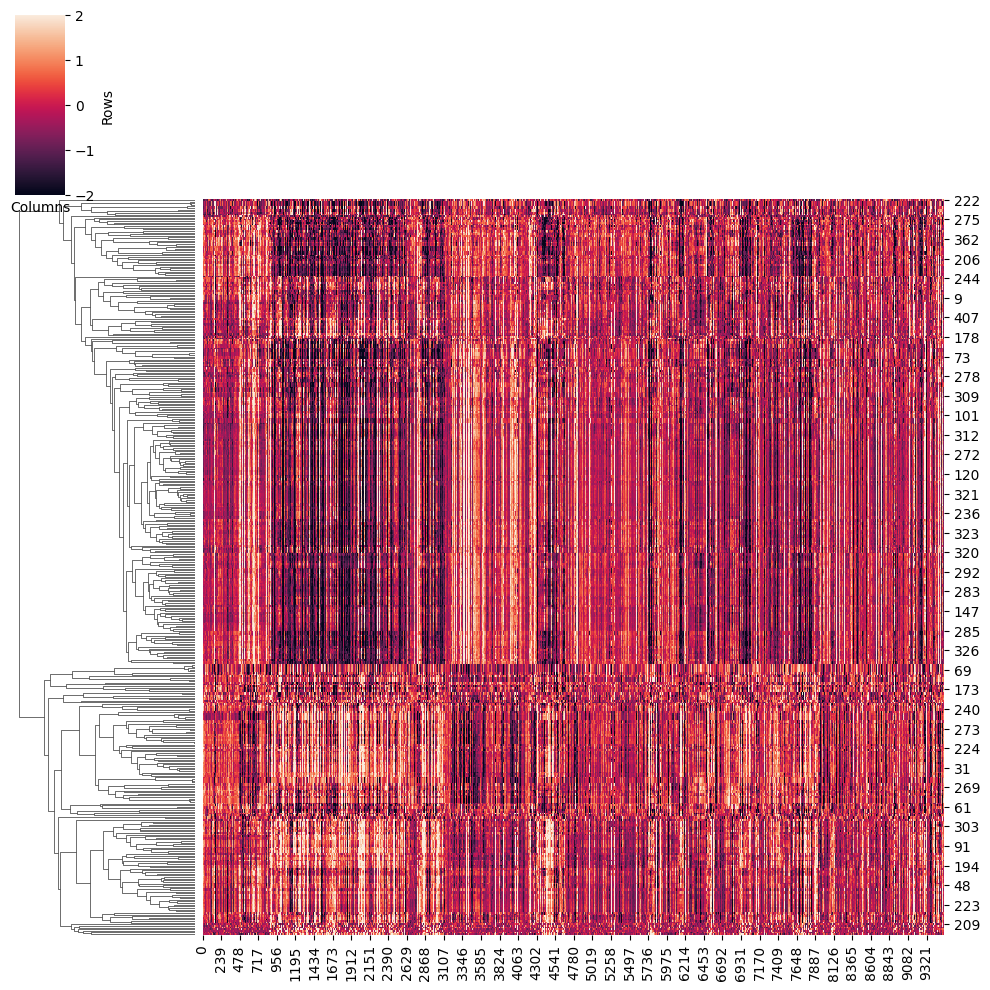

In [32]:
save=True
heatmap_cluster(TF_activity,adata_RNA,save,outdir)

### 9.1 Identify driver regulator

In [84]:
celltype = 'naive CD4 T cells'

In [64]:
t_test_results=master_regulator(TF_activity,adata_RNA,celltype)
t_test_results.head()

,t_stat,p_value,adj_p
ALX4,-6.148340,1.000000e+00,1.000000e+00
POU3F1,-15.386478,1.000000e+00,1.000000e+00
FOXJ3,-16.699544,1.000000e+00,1.000000e+00
MAX,7.517372,3.046227e-14,5.584749e-14
HSF2,12.773056,2.330129e-37,5.680477e-37


In [67]:
# Look for : High positive t_stat (activity much higher in your celltype)
#            Low adj_p (statistically significant after correction)

drivers = t_test_results[(t_test_results['t_stat'] > 0) & (t_test_results['adj_p'] < 0.05)]
drivers = drivers.sort_values('t_stat', ascending=False)

# Top driver regulators
print(drivers.head(10))

            t_stat        p_value          adj_p
SMAD3    24.514218  4.730331e-129  2.133379e-126
NR4A1    24.396764  7.091331e-128  1.599095e-125
NEUROD2  24.248509  2.127299e-126  3.198040e-124
ELK3     23.317438  2.644122e-117  2.981247e-115
TFAP4    23.251798  1.125944e-116  1.015602e-114
ZIC1     23.220628  2.237538e-116  1.681882e-114
OSR2     23.141817  1.265562e-115  8.153836e-114
NR4A2    22.984104  3.993357e-114  2.251255e-112
STAT4    22.820968  1.387810e-112  6.954469e-111
USF2     22.639034  7.068289e-111  3.187798e-109


In [60]:
top1_driver = drivers.index.tolist()[0]
top1_driver

'SMAD3'

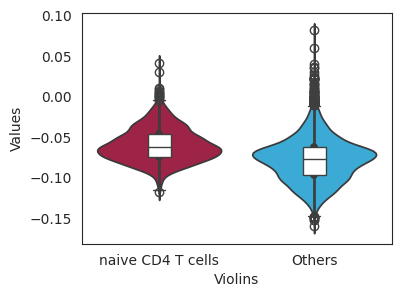

In [66]:
TFName = top1_driver
datatype = 'activity'
celltype1 = 'naive CD4 T cells'
celltype2 = 'Others'
save = True

# y axis is TF activity score (also called the regulon score).

box_comp(TFName, adata_RNA, celltype1, celltype2, datatype, TF_activity, save, outdir)

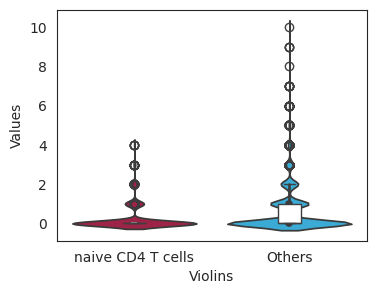

In [63]:
datatype='expression'
box_comp(TFName, adata_RNA, celltype1, celltype2, datatype, TF_activity, save, outdir)